In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('../')

In [2]:
from src.datasets.dataloader import get_dataset
from src.utils import load_obj,loader_to_tensor, to_numpy
from src.evaluations.evaluate import fake_loader
from run import *
import yaml
import ml_collections
config_dir = 'configs/PCFGAN/' + 'ou.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
config.update({"train": False}, allow_val_change=True)
train_dl, test_dl = get_dataset(config=config)
get_experiment_dir(config)
from src.models import GENERATORS,DISCRIMINATORS
if config.dataset == 'OU':
    activation = nn.Identity()
else:
    activation = nn.Tanh()
generator = GENERATORS[config.generator](
        input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim,
        n_layers=config.G_num_layers, noise_scale=config.noise_scale, BM=config.BM, activation=activation)
generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'ave_generator_state_dict.pt')), strict=True)

fake_train_dl = fake_loader(generator, num_samples=8000,
                            n_lags=config.n_lags, batch_size=128, config=config)
fake_test_dl = fake_loader(generator, num_samples=2000,
                           n_lags=config.n_lags, batch_size=128, config=config
                           )

/home/hang/anaconda3/envs/PCF-GAN/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.evaluations.evaluate import compare_hists
#from src.evaluations.test_metrics import non_stationary_acf_torch
import numpy as np
def plot_OU(real_dl, fake_dl, config,seed=0):
    sns.set()
    torch.manual_seed(seed)
    real_X, fake_X = loader_to_tensor(real_dl), loader_to_tensor(fake_dl)
    x_real_dim = real_X.shape[-1]
    plt.figure(figsize=(10, 8))
    for i in range(x_real_dim):
        plt.plot(to_numpy(fake_X[:64, :, i]).T, 'C%s' % i, alpha=0.2,color='g')  


    for i in range(x_real_dim):
        random_indices = torch.randint(0, real_X.shape[0], (64,))
        plt.plot(
            to_numpy(real_X[random_indices, :, i]).T, 'C%s' % i, alpha=0.2,color='r')
    plt.plot([],[], 'g', label='Generated')
    plt.plot([],[], 'r', label='Real')
    plt.legend(prop={'size': 18})
    plt.tight_layout()
    plt.savefig('notebooks/OU_samples.png',dpi=350)
    plt.show()
    plt.close()
    
    
    n_hists = 6
    n_lags = real_X.shape[1]
    len_interval = n_lags // n_hists
    fig = plt.figure(figsize=(10, 9))

    for i in range(n_hists):
        ax = fig.add_subplot(2, 3, i+1)
        compare_hists(to_numpy(real_X[:, (i+1)*len_interval, 0]),
                      to_numpy(fake_X[:, (i+1)*len_interval, 0]), ax=ax)
        ax.set_title("Step {}".format((i+1)*len_interval))
    fig.tight_layout()
    fig.savefig('notebooks/OU_marginal.png',dpi=350)
    plt.show()
    plt.close(fig)
    


/tmp/ipykernel_428198/3957814017.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(to_numpy(fake_X[:64, :, i]).T, 'C%s' % i, alpha=0.2,color='g')
/tmp/ipykernel_428198/3957814017.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(


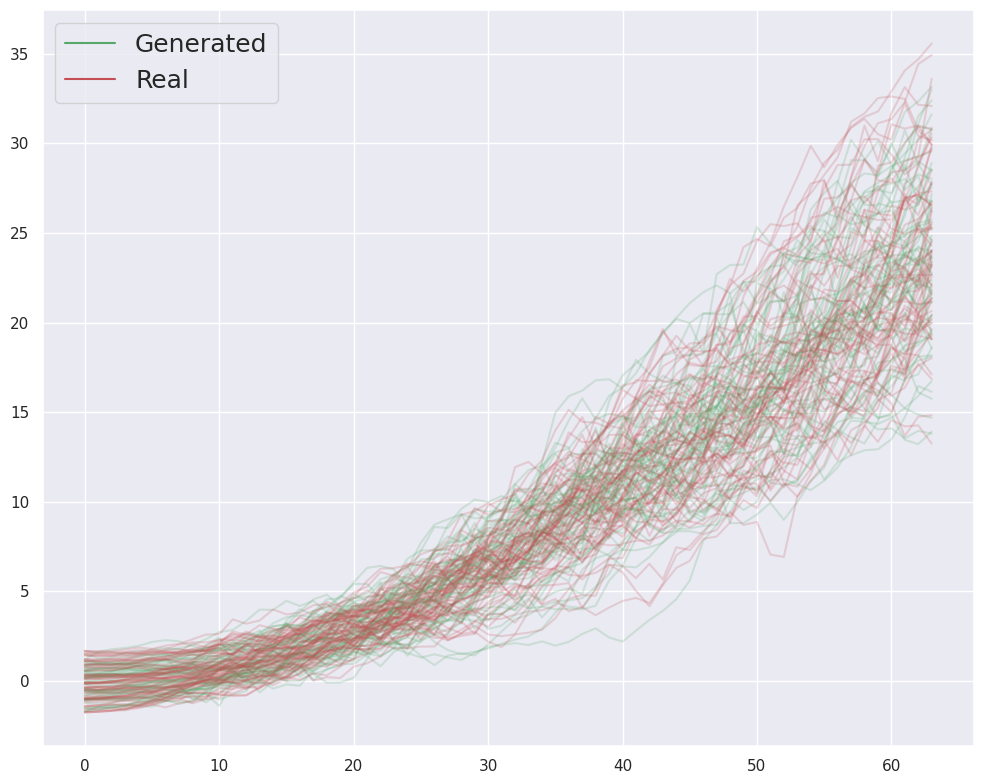

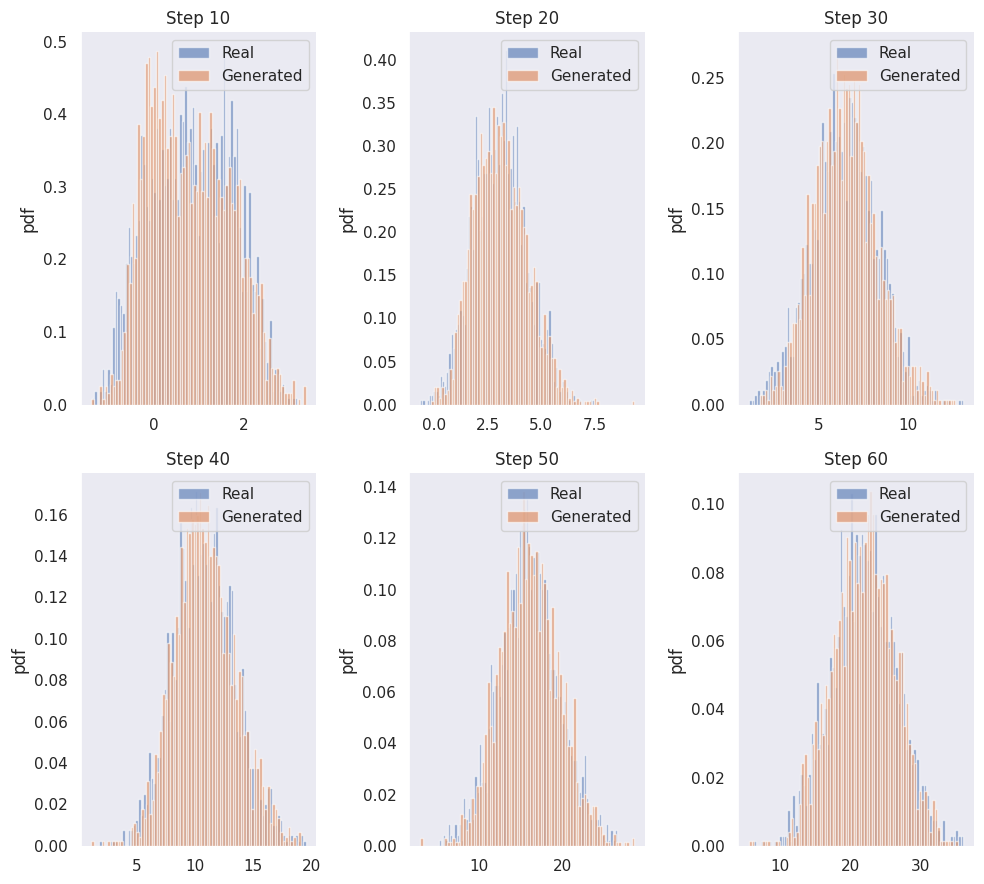

In [4]:
plot_OU(test_dl,fake_test_dl,config,seed=105)

In [5]:
def get_generated_data(config,gan_algo:str,comment:str):
    config.gan_algo = gan_algo
    config.comment =comment
    config.train = False
    get_experiment_dir(config)

    config_file = load_obj(pt.join(
        config.exp_dir, 'config.pkl'))

    config = config_file
    from src.models import GENERATORS
    activation = None
    config.train = False
    get_experiment_dir(config)
    from src.datasets.dataloader import get_dataset
    train_dl, test_dl = get_dataset(config, num_workers=4)
    from src.models import get_trainer
    trainer, generator = get_trainer(config, train_dl, test_dl)

    if config.gan_algo == 'TimeGAN':
        generator = generator.to(device='cpu')
        generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'ave_generator_state_dict.pt')), strict=True)
        supervisor = trainer.supervisor.to(
            device='cpu')
        supervisor.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'supervisor_state_dict.pt')), strict=True)
        recovery = trainer.recovery.to(device='cpu')
        recovery.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'recovery_state_dict.pt')), strict=True)

        recovery = nn.Sequential(trainer.supervisor.to(
            device='cpu'), trainer.recovery.to(device='cpu'))
        generator.eval()
        fake_dl = fake_loader(generator, num_samples=10000,
                                   n_lags=config.n_lags, batch_size=128, config=config, recovery=recovery)
    else:
        generator = generator.to(device='cpu')
        generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'ave_generator_state_dict.pt')), strict=True)
        generator.eval()
        fake_dl = fake_loader(generator, num_samples=10000,
                                   n_lags=config.n_lags, batch_size=128, config=config
                                   )
    return loader_to_tensor(fake_dl),torch.cat([loader_to_tensor(train_dl),
                  loader_to_tensor(test_dl)])

In [6]:
def plot_samples(data,seed=100):
    
    torch.manual_seed(seed)
   # data = 'stock'
    gan_algo = ['Real','RPathChar_GAN','TimeGAN','RCGAN','COTGAN']
    comment = [None,None,None,None,None]
    config_dir = 'configs/PCFGAN/'+data+'.yaml'
    
    with open(config_dir) as file:
            config = ml_collections.ConfigDict(yaml.safe_load(file))
    data_list = [] 
    data_list.append(get_generated_data(config,gan_algo[1],comment[0])[1])
    for i in range(1,len(gan_algo)): 
        data_list.append(get_generated_data(config,gan_algo[i],comment[i])[0])
    
    sns.set()
    fig, axs = plt.subplots(len(data_list), 8,figsize=(12, 8))
    
    
    for i in range(len(data_list)):
        data = data_list[i]
        x_real_dim = data.shape[-1]
        random_indices = torch.randint(0, data.shape[0], (10,))
        for j in range(8):
            for k in range(x_real_dim):
                axs[i][j].plot(to_numpy(data[random_indices[j], :, k]).T)
            axs[i,j].get_shared_y_axes().join(axs[i,j],axs[i,0])
            axs[i,j].get_shared_x_axes().join(axs[i,j],axs[0,j])
            if j !=0:
                axs[i,j].set_yticklabels([])
            if i!=len(data_list)-1:
                axs[i,j].set_xticklabels([])
    for ax, row in zip(axs[:,0],gan_algo):
        if row =='RPathChar_GAN':
            row = 'PCF-GAN'
        if row =='RCGAN':
            row = 'RGAN'
        if row =='COTGAN':
            row = 'COT-GAN'
        ax.set_ylabel(row, rotation=60)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    plt.savefig('notebooks/'+config.dataset+'_samples.png')
    plt.show()

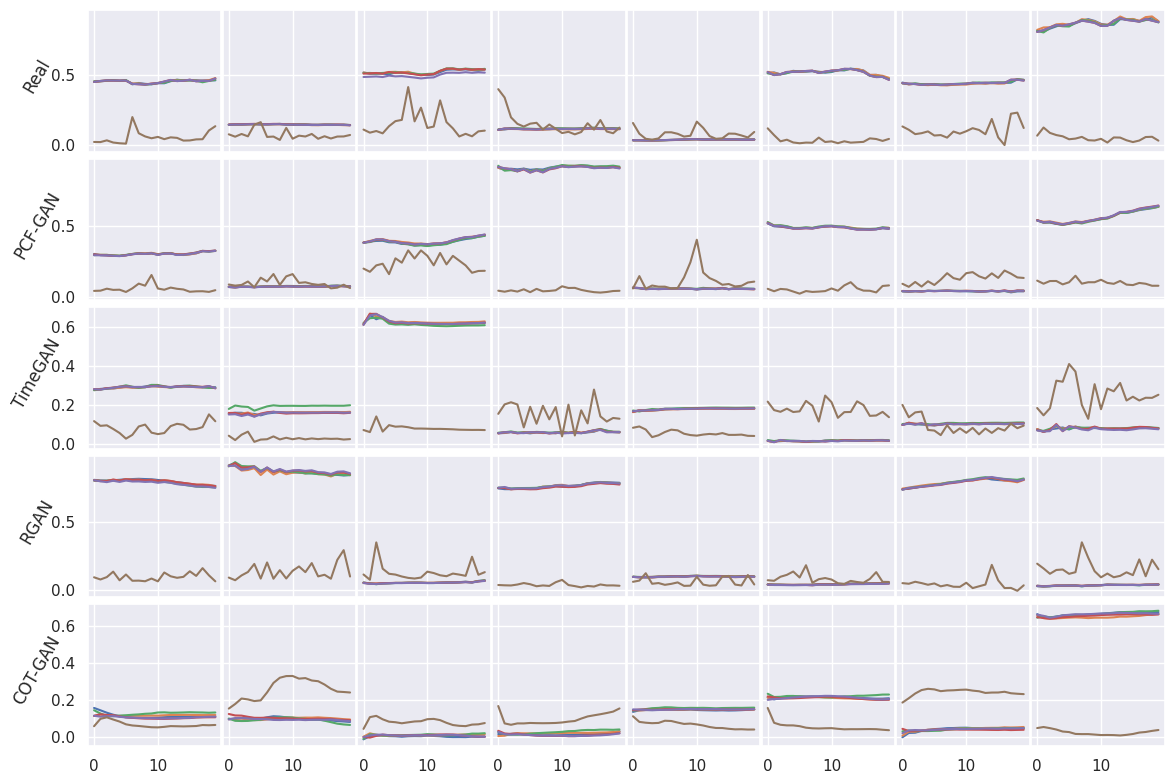

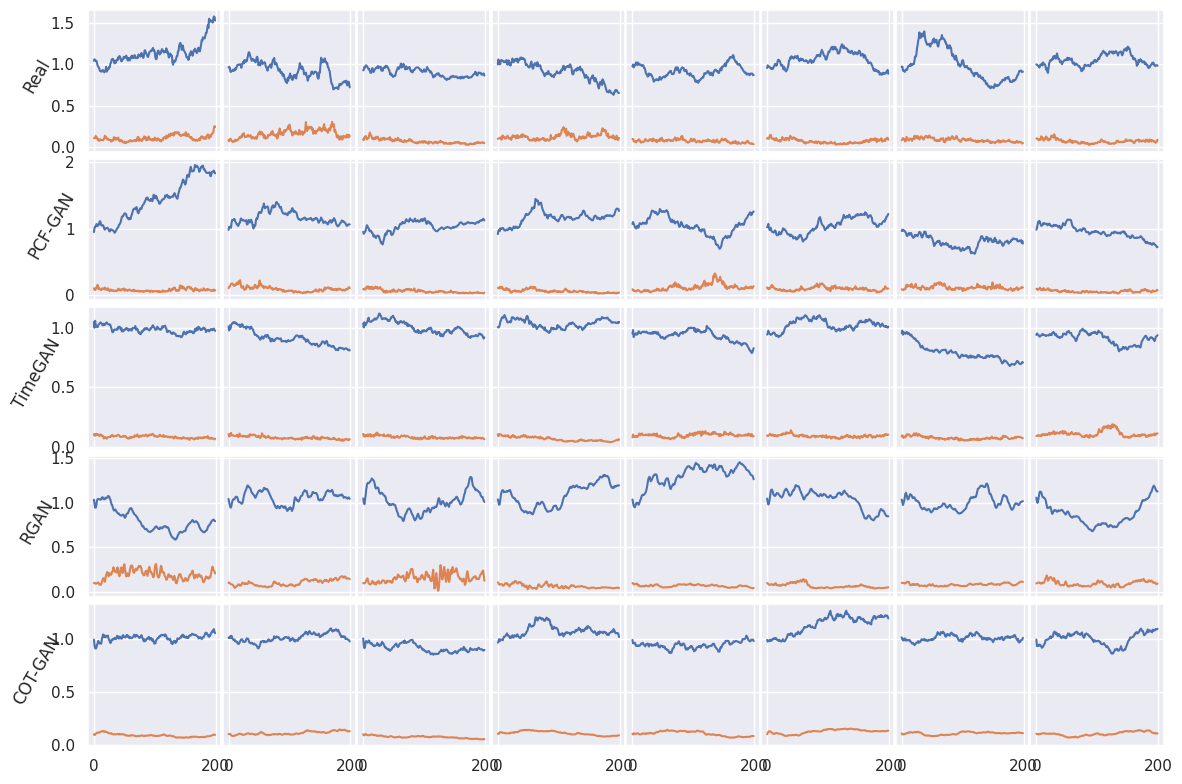

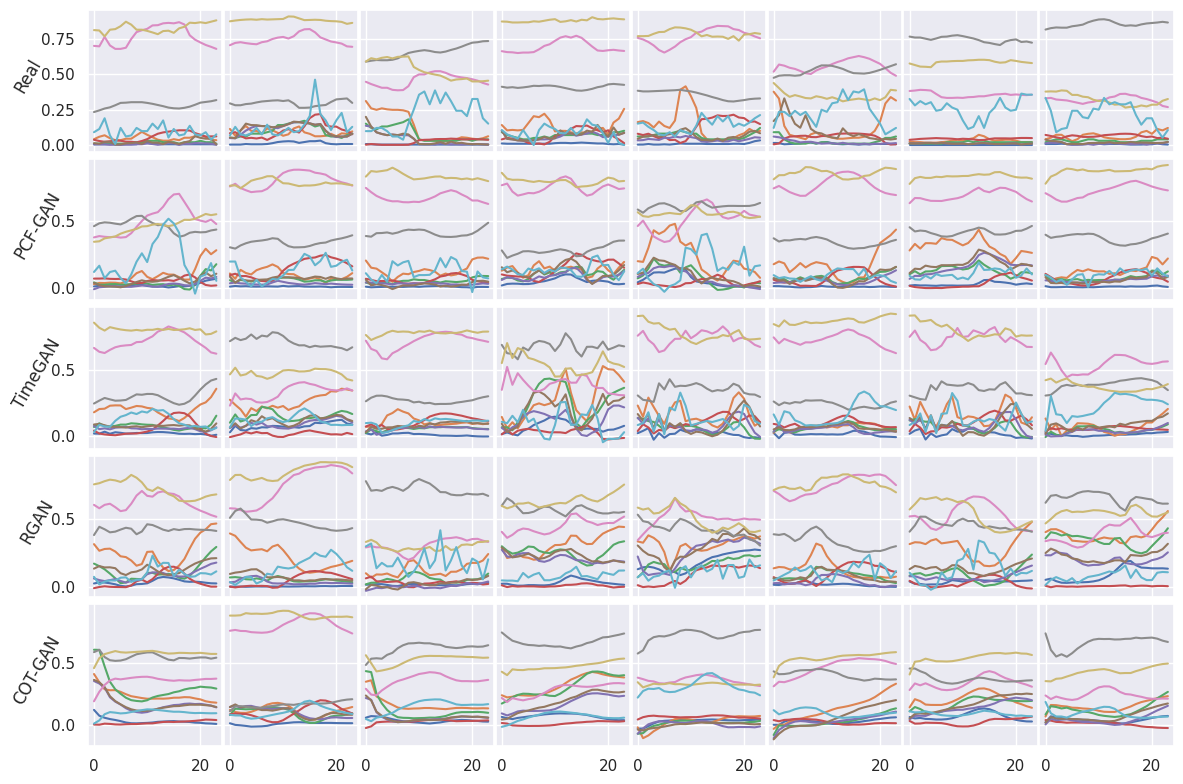

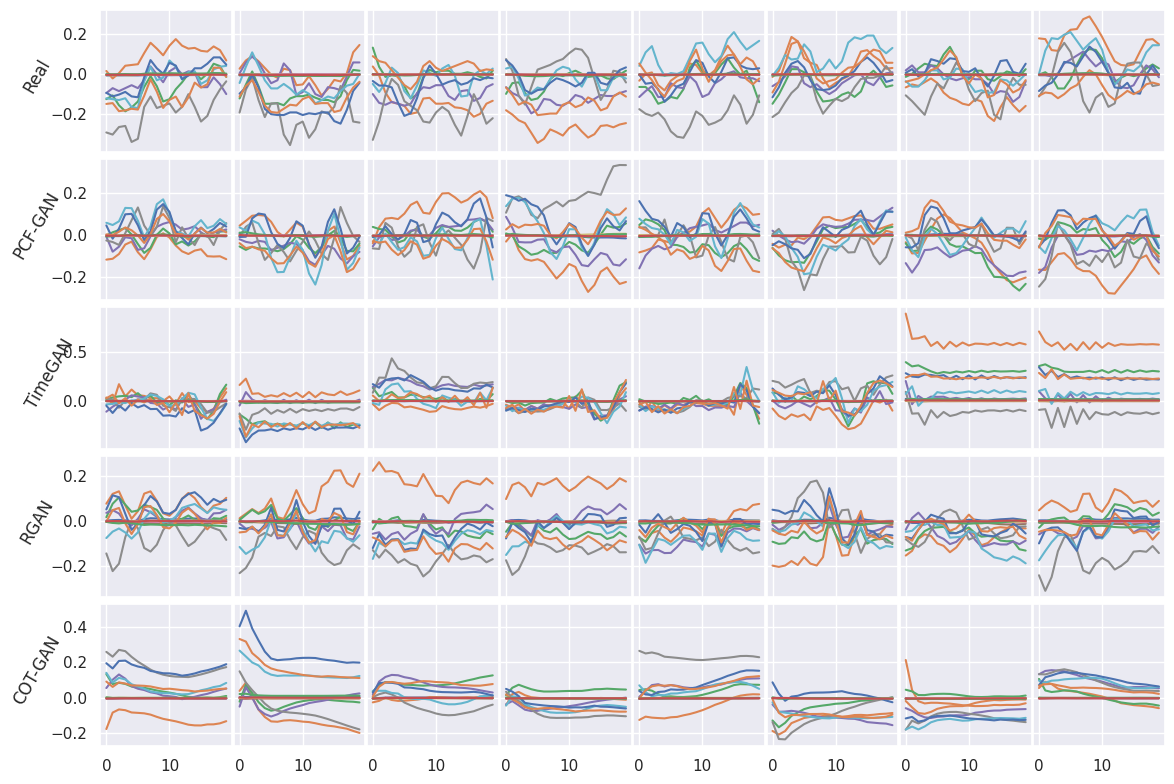

In [19]:
plot_samples('stock')
plot_samples('rough')
plot_samples('air_quality')
plot_samples('eeg')

In [9]:
def get_reconstructed_data(config,gan_algo:str,comment:str,seed:int):
    if gan_algo =='PCFGAN':
        config.gan_algo = 'RPathChar_GAN'
    else:
        config.gan_algo = gan_algo
     
    torch.manual_seed(seed)
    config.comment =comment

    config.train = False
    get_experiment_dir(config)

    config_file = load_obj(pt.join(
        config.exp_dir, 'config.pkl'))

    config = config_file
   
    from src.models import GENERATORS
    activation = None
    config.train = False
    get_experiment_dir(config)
    from src.datasets.dataloader import get_dataset
    train_dl, test_dl = get_dataset(config, num_workers=4)
    from src.models import get_trainer
    trainer, generator = get_trainer(config, train_dl, test_dl)

    if config.gan_algo == 'TimeGAN':
        generator = generator.to(device='cpu')
        generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'generator_state_dict.pt')), strict=True)
        embedder = trainer.embedder.to(device='cpu')
        embedder.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'embedder_state_dict.pt')), strict=True)
        recovery = trainer.recovery.to(device='cpu')
        recovery.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'recovery_state_dict.pt')), strict=True)

        d = nn.Sequential(embedder,recovery)
        generator.eval()
    else:
        generator = generator.to(device='cpu')
        generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'generator_state_dict.pt')), strict=True)
        d = trainer.D.to(device='cpu')
        d.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'discriminator_state_dict.pt')), strict=True)
        generator.eval()
    real_X =loader_to_tensor(test_dl)
    if config.gan_algo == 'TimeGAN':
        rec_X = recovery(real_X)
        
    else:
        z = d(real_X)
        rec_X = generator(batch_size=real_X.shape[0],n_lags=config.n_lags,device='cpu',z=z)
    
    return real_X,rec_X

In [10]:
import matplotlib.gridspec as gridspec
def plot_reconstructed_sample(gan_algo,gan_algo1,data_list=['rough','stock','air_quality','eeg'],seed=100):
        sns.set()
        real_X_list = []
        rec_X_list = []
        rec_X_list1 = []
        for data in data_list:
            config_dir = 'configs/'+gan_algo+'/'+data+'.yaml'
    
            with open(config_dir) as file:
                config = ml_collections.ConfigDict(yaml.safe_load(file))
            real_X,rec_X  = get_reconstructed_data(config,gan_algo,'None',seed)
            real_X_list.append(real_X)
            rec_X_list.append(rec_X)
        for data in data_list:
            config_dir = 'configs/'+gan_algo1+'/'+data+'.yaml'
    
            with open(config_dir) as file:
                config = ml_collections.ConfigDict(yaml.safe_load(file))
            real_X,rec_X  = get_reconstructed_data(config,gan_algo1,'None',seed)
            real_X_list.append(real_X)
            rec_X_list1.append(rec_X)
        sns.set()
        torch.manual_seed(seed)
        fig = plt.figure(figsize=(15, 4))
        gs0 = gridspec.GridSpec(1, 3, figure=fig,wspace = 0.1)
        data = ['RV','Stock','Air','EEG']
        
        for j in range(3):
            gs1 = gridspec.GridSpecFromSubplotSpec(len(data_list), 3, subplot_spec=gs0[j],wspace=0,hspace=0.05)
            for i in range(len(data_list)):
                real_data = real_X_list[i]
                rec_data  = rec_X_list[i]
                rec_data1  = rec_X_list1[i]
                x_real_dim = real_data.shape[-1]
                random_indices = torch.randint(0, real_data.shape[0], (3,))
                for s in range(3):
                    ax = fig.add_subplot(gs1[i,s])
                    if s==0:
                        for k in range(x_real_dim):
                            ax.plot(to_numpy(real_data[random_indices[j], :, k]).T)
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)
                            if i == 0:
                                 ax.set_title('Real')
                            else:
                                pass
                            
                            
                        if j == 0:
                            print(data[i])
                            ax.get_yaxis().set_visible(True)
                            ax.set_yticklabels([])
                            ax.set_ylabel(data[i],rotation=60)
                    elif s==1:
                        for k in range(x_real_dim):
                            ax.plot(to_numpy(rec_data[random_indices[j], :, k]).T)
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)
                            if i == 0:
                                ax.set_title('PCF-GAN')
                    elif s==2:
                        for k in range(x_real_dim):
                            ax.plot(to_numpy(rec_data1[random_indices[j], :, k]).T)
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)
                            if i == 0:
                                ax.set_title('TimeGAN')
               
 
        plt.tight_layout()
        plt.savefig('notebooks/'+'reconstruction.png',bbox_inches='tight')
        plt.show()


RV
Stock
Air
EEG


/tmp/ipykernel_428198/4122854446.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


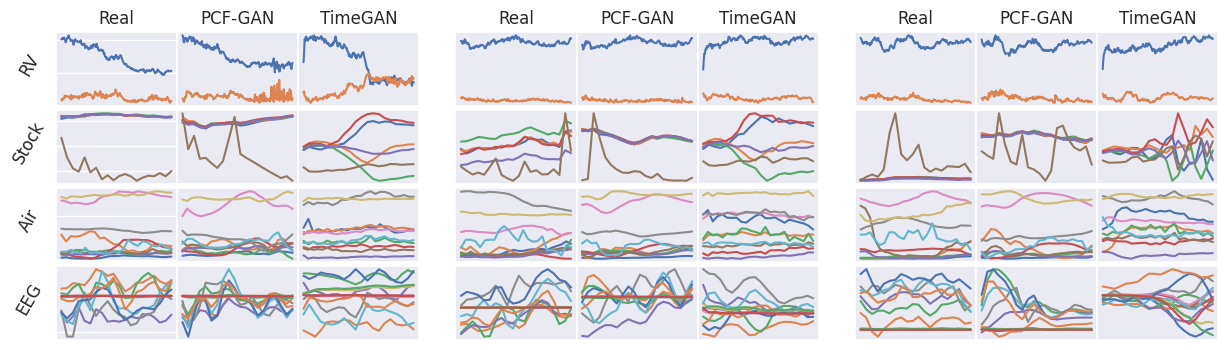

In [11]:
plot_reconstructed_sample('PCFGAN','TimeGAN',data_list=['rough','stock','air_quality','eeg'],seed=1)

In [14]:
import pandas as pd
config_dir = 'configs/'+'PCFGAN/rough'+'.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
config.train = False
get_experiment_dir(config)
loss_history = load_obj(pt.join(config.exp_dir, "losses_history.pkl"))

In [15]:
loss = pd.DataFrame({'generator loss':loss_history['G_loss'],'recovery loss':loss_history['recovery_loss'],'regularization loss':loss_history['regularzation_loss']})

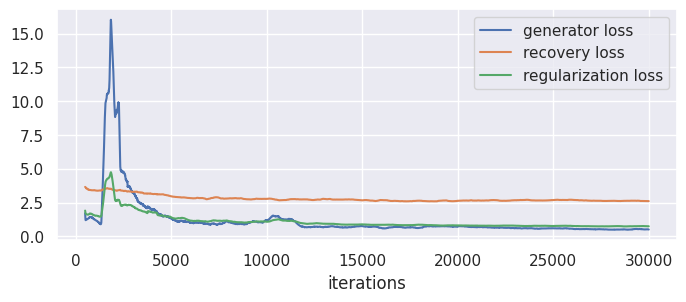

In [16]:
import seaborn as sns
sns.set()
plt.figure(figsize=(8,3))
fig=sns.lineplot(data=loss.rolling(window=500).mean(), dashes=False)
fig.set(xlabel='iterations')
#fig.set(yticklabels=[])
plt.savefig('notebooks/'+'training_loss.png',bbox_inches='tight')

## Hypothesis testing

In [17]:
test_metrics_df = pd.read_csv('numerical_results/metric_compare_fbm.csv')
test_metrics_df

,Unnamed: 0,model,power,type1 error,tag
0,0,PCF,1.000,0.000,0.2
1,1,Optimized PCF,1.000,0.000,0.2
2,2,CF,0.048,0.956,0.2
3,3,PCF,1.000,0.000,0.2
4,4,Optimized PCF,1.000,0.000,0.2
...,...,...,...,...,...
190,10,Optimized PCF,1.000,0.000,0.8
191,11,CF,0.072,0.950,0.8
192,12,PCF,1.000,0.010,0.8
193,13,Optimized PCF,1.000,0.000,0.8


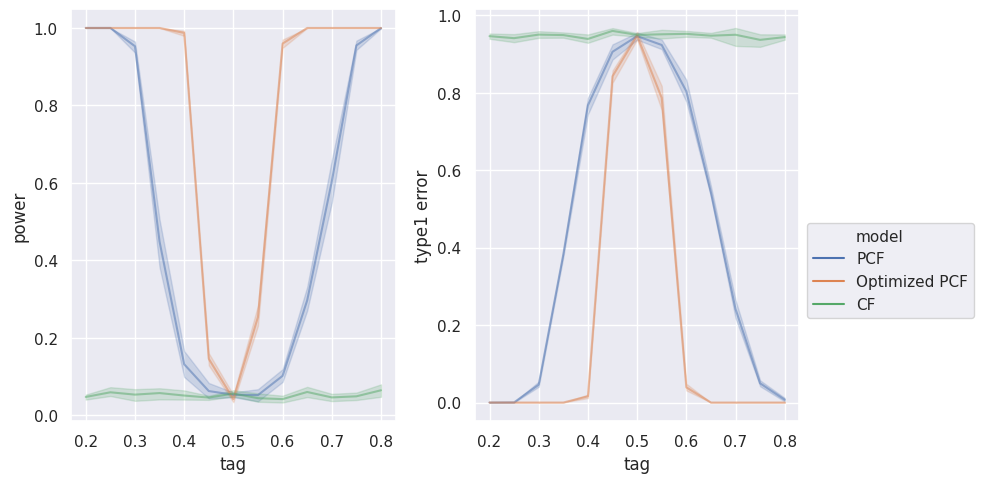

In [18]:
sns.set()
fig, axes = plt.subplots(1,2,figsize=(10, 5))
sns.lineplot(ax=axes[0],data=test_metrics_df, x="tag", y="power",hue='model',alpha=0.5,legend=False)
ax = sns.lineplot(ax=axes[1],data=test_metrics_df, x="tag", y="type1 error",hue='model',alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig('numerical_results/HT_plot.png',dpi=250)
#fig.legend(labels, loc='lower right')